In [1]:
from pathlib import Path

from src.stop_detection import stop_table, StopFeatures

import pandas as pd
import matplotlib.pyplot as plt

/home/borza/data-venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
sdf = stop_table.get_full_df(env="complete").assign(
    duration=lambda df: (
        df[StopFeatures.interval.end] - df[StopFeatures.interval.start]
    ).dt.total_seconds()
    / 60
    / 60,
    hour=lambda df: df[StopFeatures.interval.start].dt.hour
)

/home/borza/data-venv/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44741 instead
  warnings.warn(


In [3]:
not_home_df = sdf.loc[~sdf[StopFeatures.is_home], :]

In [4]:
home_df = sdf.loc[sdf[StopFeatures.is_home], :]

In [5]:
sdf.shape, home_df.shape, not_home_df.shape

((10917077, 20), (3783711, 20), (7133366, 20))

In [6]:
hf_dic = {
        "Found Workplace": pd.NamedAgg(StopFeatures.is_work, "max"),
        "Found Home": pd.NamedAgg(StopFeatures.is_home, "max"),
}

In [7]:
agg_dic = {
        "Unique Places Visited": pd.NamedAgg(StopFeatures.place_label, "nunique"),
        "Total Stops": pd.NamedAgg(StopFeatures.stop_number, "count"),
        "Total Time Detected as Stops (hours)": pd.NamedAgg("duration", "sum"),
        "Average Number of Events in a Stop": pd.NamedAgg(
            StopFeatures.n_events, "mean"
        ),
        "Median Time Spent in a Stop (hours)": pd.NamedAgg("duration", "median"),
        "Median Distance from Last Stop (meters)": pd.NamedAgg(
            StopFeatures.from_last_stop.distance, "median"
        ),
    }

In [8]:
all_agged = sdf.groupby(StopFeatures.device_id).agg(**agg_dic, **hf_dic)

In [9]:
all_agged.mean().to_frame()

,0
Unique Places Visited,22.433854
Total Stops,132.450221
Total Time Detected as Stops (hours),666.137081
Average Number of Events in a Stop,59.732968
Median Time Spent in a Stop (hours),6.035008
Median Distance from Last Stop (meters),1611.411040
Found Workplace,0.918956
Found Home,0.634997


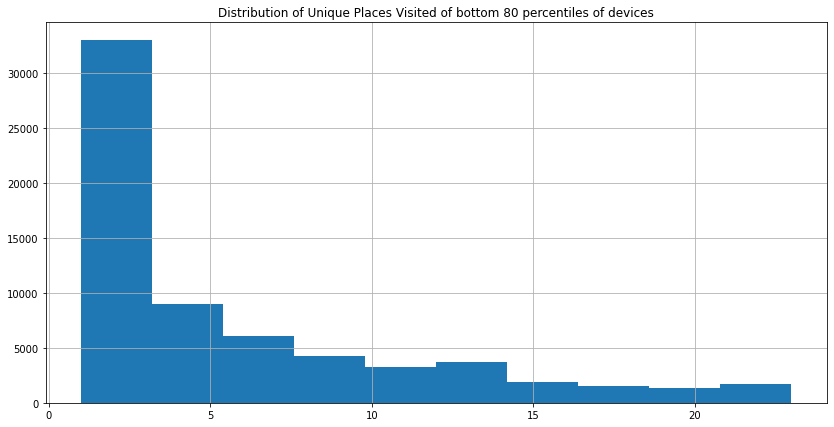

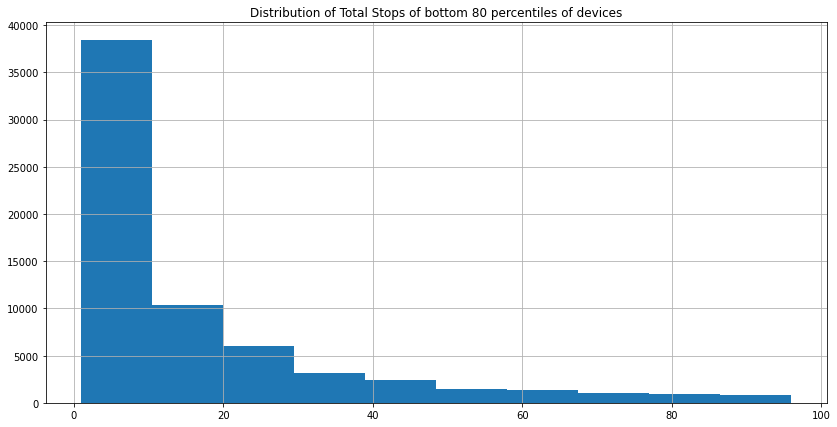

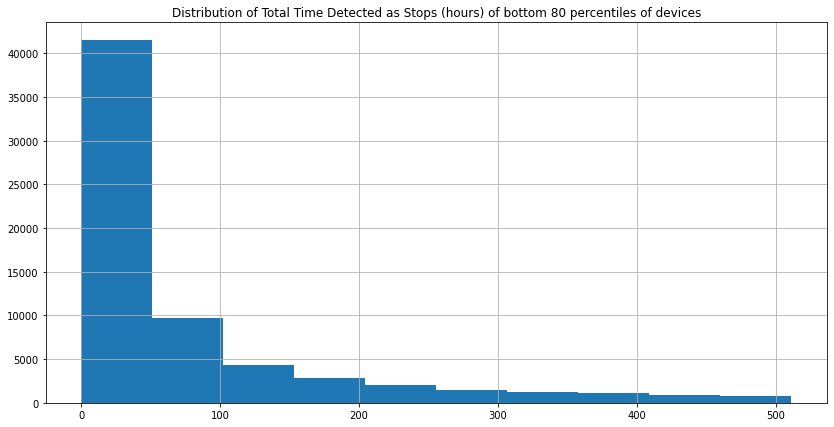

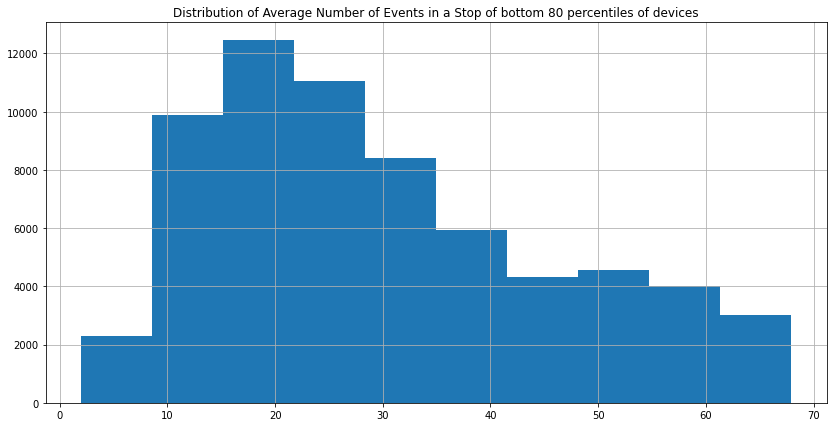

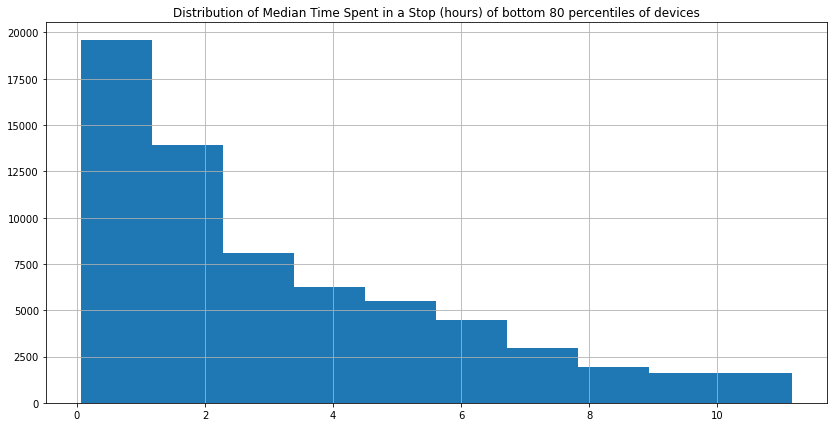

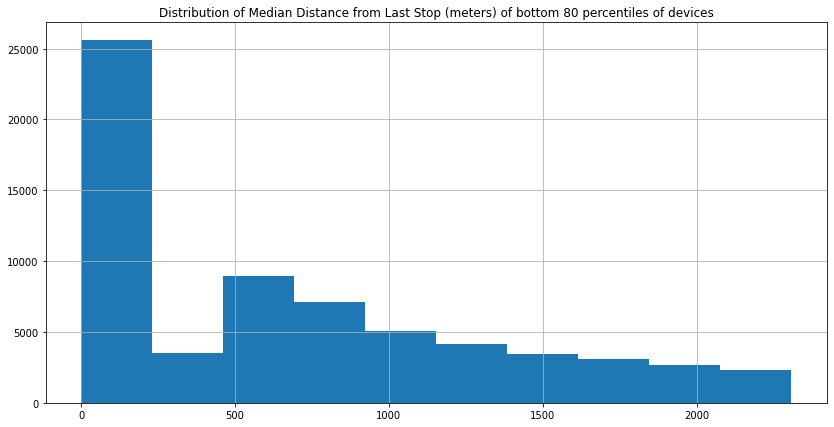

In [10]:
for c in agg_dic.keys():
    ax = all_agged.loc[:, c].loc[lambda s: s < s.quantile(0.8)].hist(figsize=(14,7))
    ax.set_title(f"Distribution of {c} of bottom 80 percentiles of devices")
    plt.show()


In [11]:
suffixed_maggs = [
    (
        _df.groupby([StopFeatures.device_id, StopFeatures.year_month])
        .agg(**agg_dic)
        .reset_index()
        .groupby(StopFeatures.year_month)
        .agg(
            {**{c: "mean" for c in agg_dic}, StopFeatures.device_id: "nunique"},
        )
        .rename(columns={StopFeatures.device_id: "Unique Devices with Stops Detected"}),
        suffix,
    )
    for _df, suffix in [
        (sdf, "Total"),
        (home_df, "Restricted to Pings Detected from Home"),
        (not_home_df, "Restricted to Pings Detected Away from Home"),
    ]
]

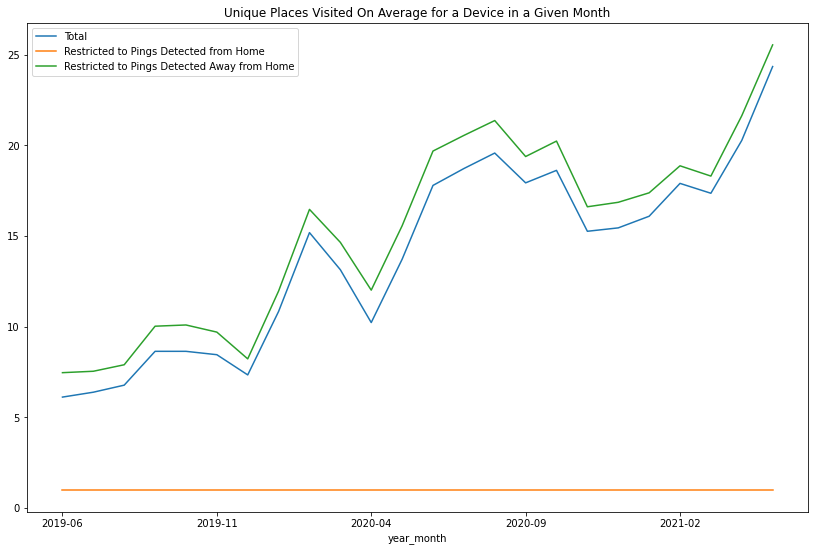

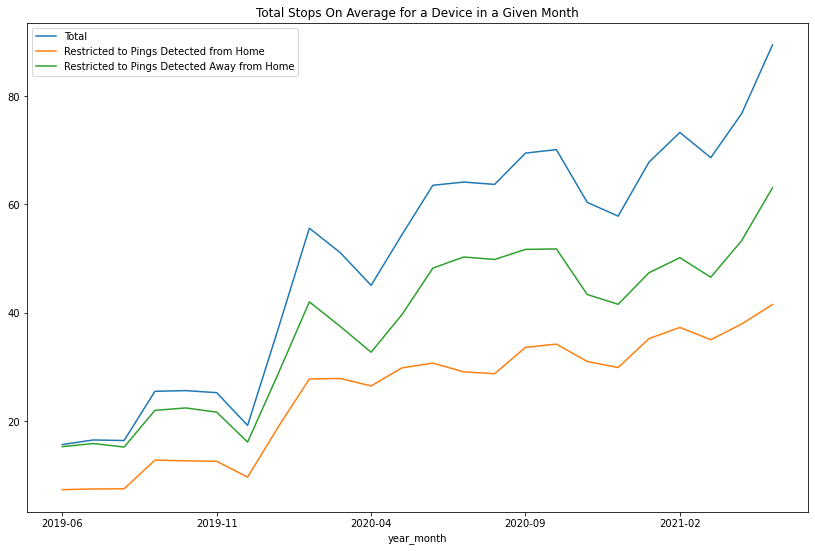

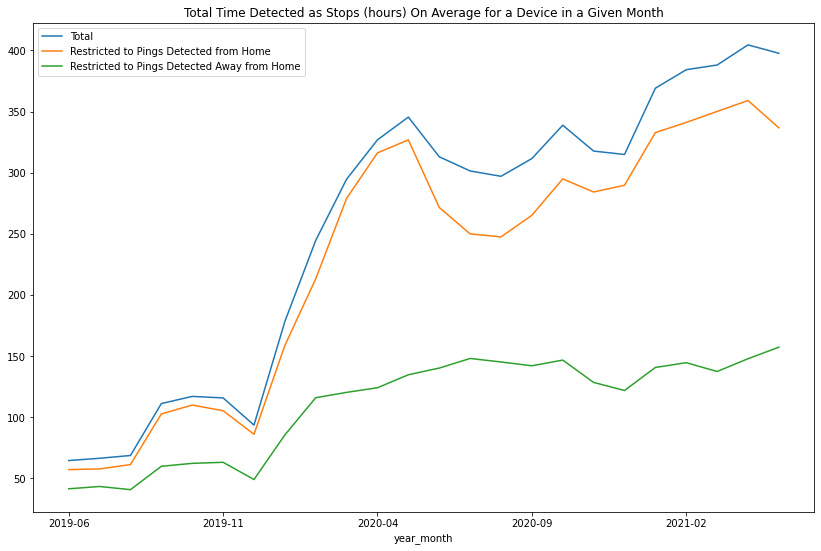

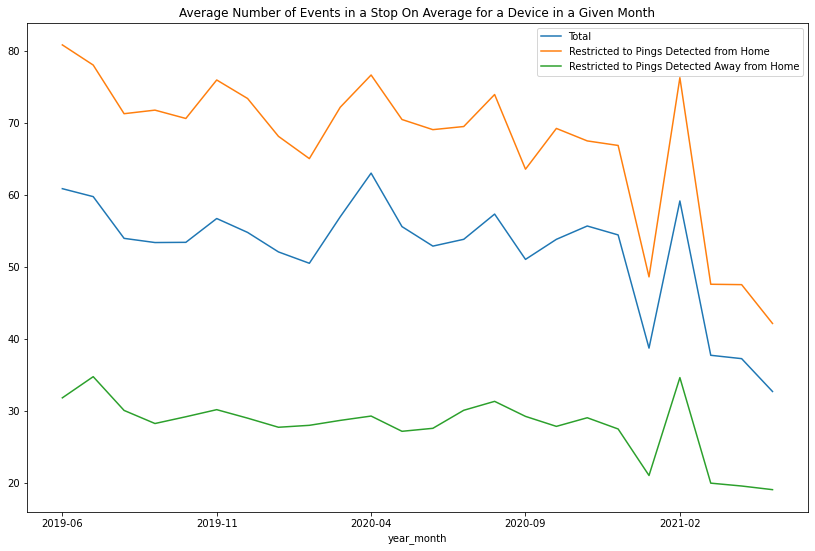

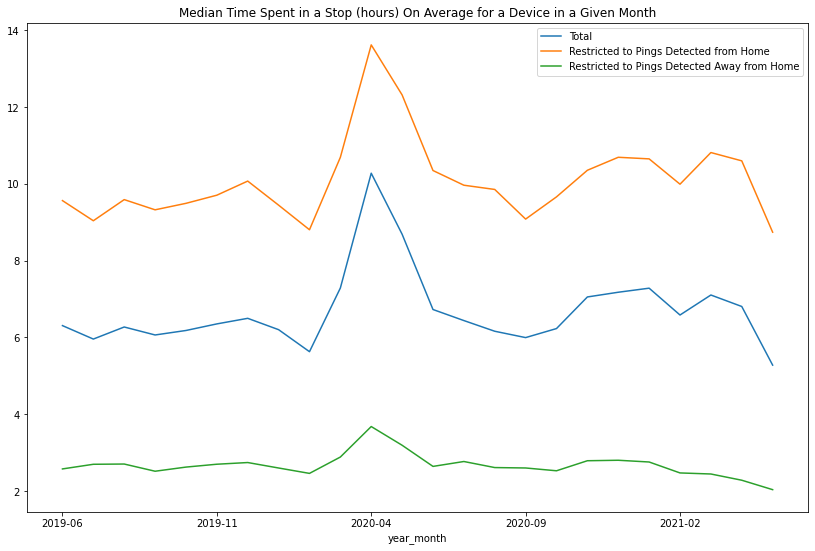

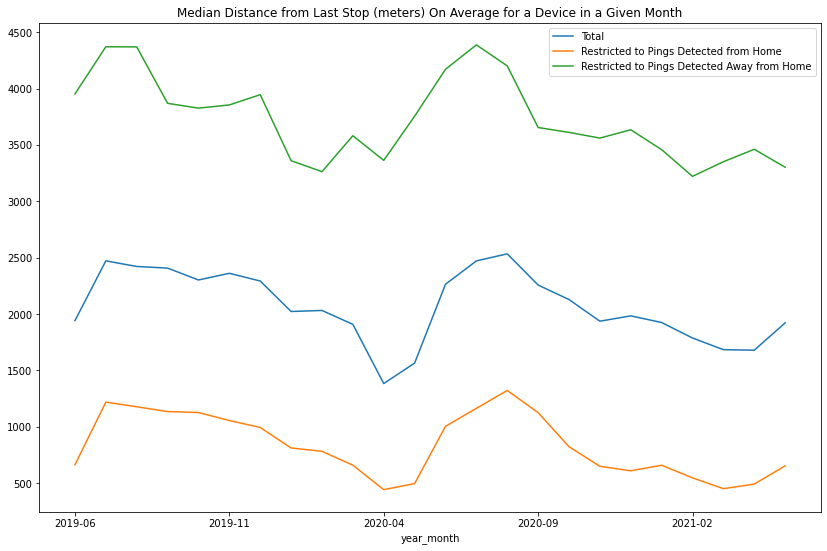

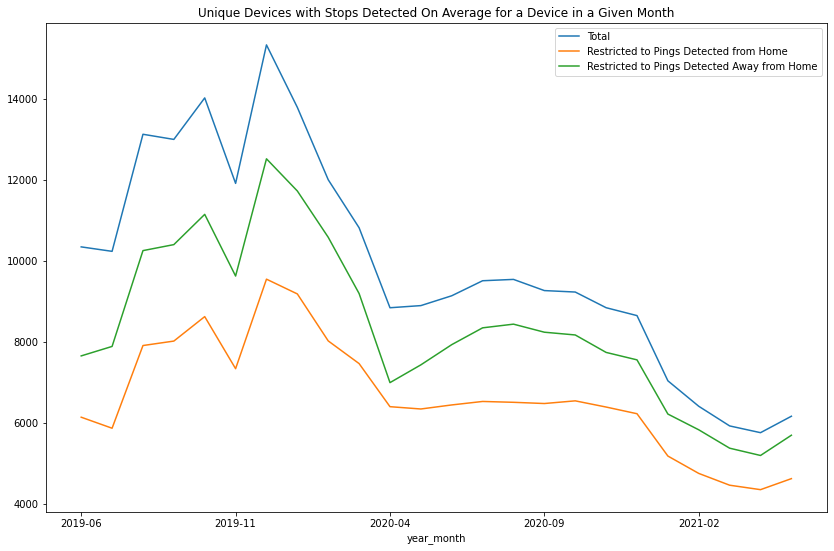

In [12]:
for col in suffixed_maggs[0][0].columns:
    _df = pd.concat(
        [
            _magg.loc[:, col].rename(suf).to_frame()
            for _magg, suf in suffixed_maggs
        ],
        axis=1,
    )
    ax = _df.plot(figsize=(14, 9))
    ax.set_title(f"{col} On Average for a Device in a Given Month")

In [13]:
# daily routines

In [14]:
hourcols = [
    "duration",
    StopFeatures.from_last_stop.speed,
    StopFeatures.from_last_stop.distance,
    StopFeatures.from_last_ping.speed,
    StopFeatures.from_last_ping.distance,
]

In [15]:
month_filters = [
    set(["2019-08", "2019-09"]),
    set(["2020-03", "2020-04", "2020-05"]),
    set(["2020-08", "2020-09"]),
    set(["2020-04"]),
    set(["2021-02"]),
]

In [16]:
timefil_sdfs = [(sdf, "Full")] + [
    (sdf.loc[sdf[StopFeatures.year_month].isin(mf)], "+".join(sorted(mf)))
    for mf in month_filters
]

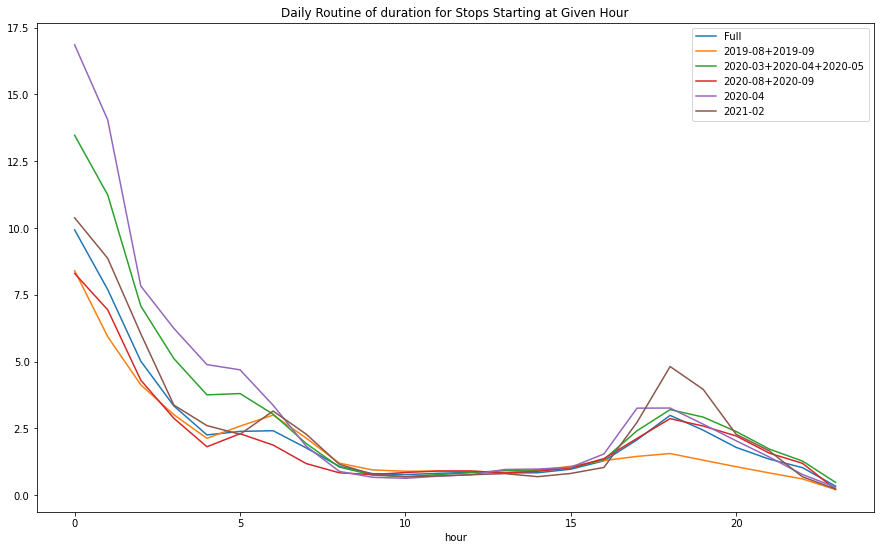

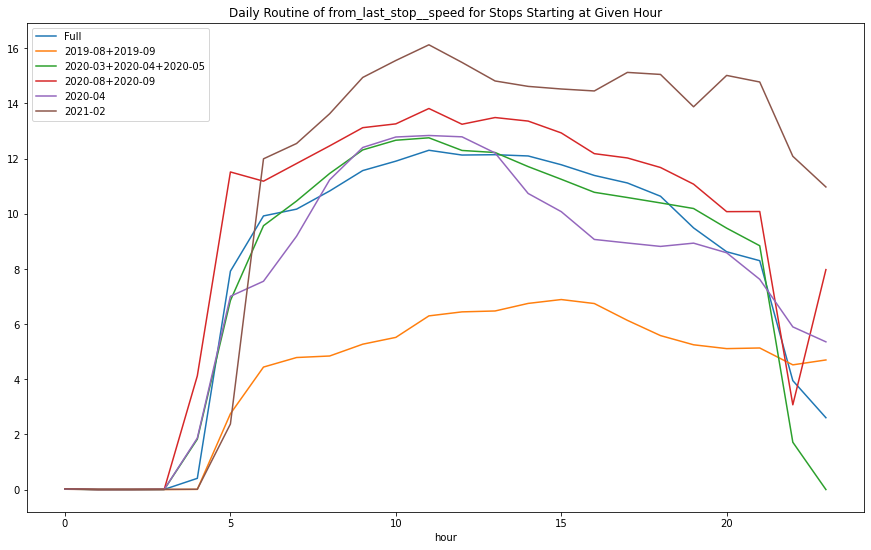

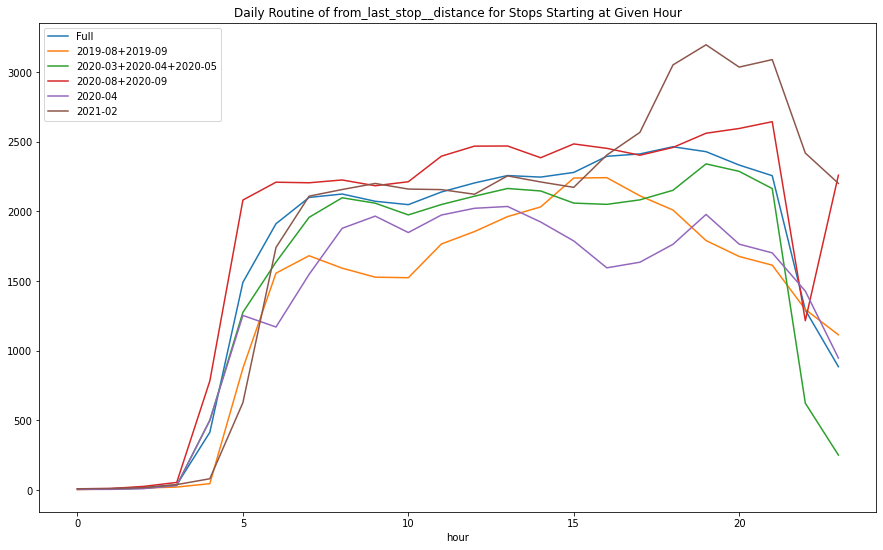

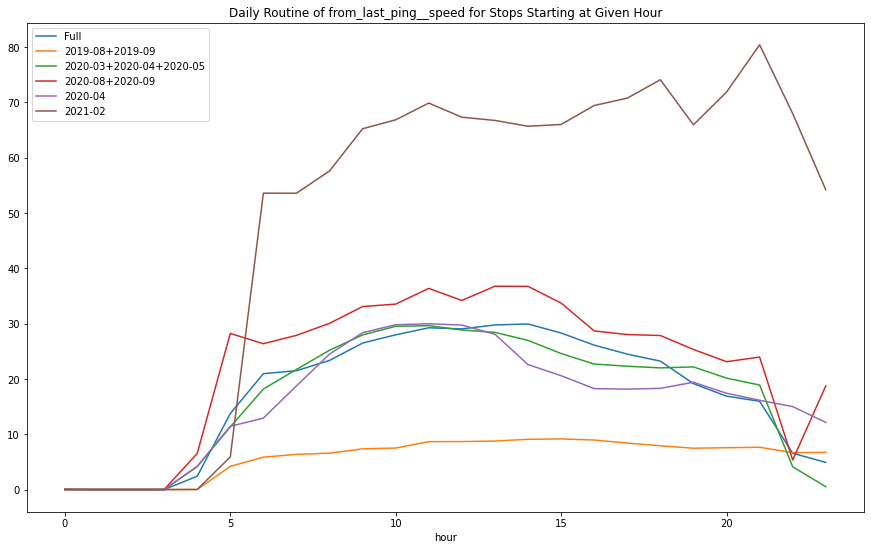

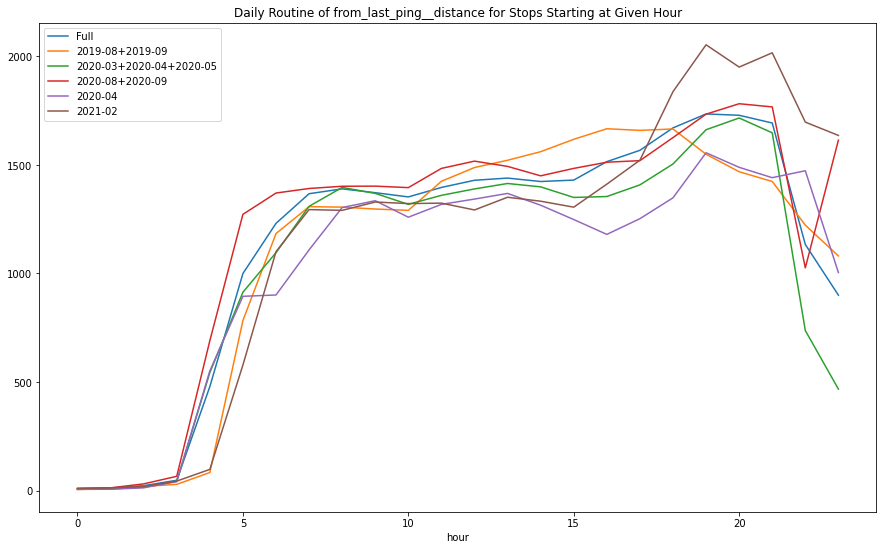

In [17]:
for hourcol in hourcols:
    _df = pd.DataFrame(
        {name: _sdf.groupby("hour")[hourcol].median() for _sdf, name in timefil_sdfs}
    )
    ax = _df.plot(figsize=(15, 9))
    ax.set_title(f"Daily Routine of {hourcol} for Stops Starting at Given Hour")
    plt.show()

In [18]:
# for stops starting in the given hour
sdf.groupby("hour")[hourcols].median().style.background_gradient(axis=0)

,duration,from_last_stop__speed,from_last_stop__distance,from_last_ping__speed,from_last_ping__distance
hour,,,,,
0,9.930556,0.020462,8.235323,0.020595,8.273868
1,7.698056,0.003696,10.468287,0.003895,11.140349
2,5.018056,0.004372,18.637052,0.004936,22.205947
3,3.340556,0.007098,38.517820,0.007988,47.321307
4,2.257222,0.408271,415.099034,2.401263,478.673206
5,2.388889,7.918931,1491.079917,13.734669,999.919223
6,2.414444,9.922819,1911.261669,20.945656,1231.023814
7,1.771111,10.168958,2099.725510,21.482218,1367.642241
8,1.081667,10.827175,2124.359199,23.337637,1389.954122


In [19]:
# same thing for main covid
sdf.loc[lambda df: df[StopFeatures.year_month] == "2020-04"].groupby("hour")[
    hourcols
].median().style.background_gradient(axis=0)

,duration,from_last_stop__speed,from_last_stop__distance,from_last_ping__speed,from_last_ping__distance
hour,,,,,
0,16.856528,0.013531,5.272366,0.013576,5.282004
1,14.047222,0.001968,5.837432,0.002002,5.979633
2,7.830278,0.002167,11.224743,0.002314,12.456849
3,6.245000,0.005597,33.315103,0.006160,41.016534
4,4.888750,1.867411,501.623703,4.204708,551.131862
5,4.693611,7.008438,1253.461650,11.434256,894.903984
6,3.367222,7.554305,1170.462106,12.912832,900.981514
7,1.834167,9.187618,1547.719756,18.739593,1108.710733
8,0.893056,11.232236,1878.427345,24.487928,1303.890696


In [20]:
sdf.shape

(10917077, 20)

In [21]:
sdf.drop_duplicates(subset=[StopFeatures.device_id, StopFeatures.interval.start]).shape

(10917051, 20)